# CSE 252B: Computer Vision II, Winter 2022 – Assignment 4
### Instructor: Ben Ochoa
### Due: Wednesday, March 2, 2022, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (this is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. If you are uncertain about using a specific package, then please ask the instructional staff whether or not it is allowable.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

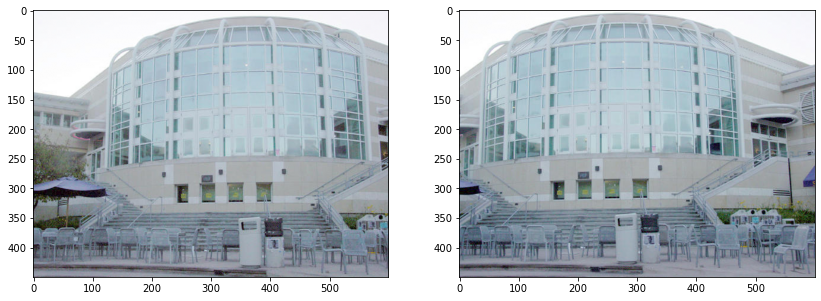

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from scipy.signal import convolve
from scipy import ndimage

# open the input images
I1 = np.array(Image.open('price_center20.jpeg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpeg'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

## Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.jpeg
contains image 1 and the file price_center21.jpeg contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features

A typical implementation takes around <strong>30</strong> seconds to run. If yours takes more than <strong>60</strong> seconds, you may lose points.

In [2]:
def ImageGradient(I):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    
    m, n = I.shape[:2]
    
    # Define filter kernel
    f = np.array([[-1,8,0,-8,1]])/12
    if(I.ndim == 3):
        # RGB Image
        filter_x = f[..., np.newaxis]
        filter_y = np.transpose(filter_x, (1,0,2))
    else:
        filter_x = f
        filter_y = f.T
    
    # Convolve to generate gradient images
    I_x = convolve(I, filter_x, mode = 'valid')
    I_y = convolve(I, filter_y, mode = 'valid')
    
    # Pad gradient image to restore original shape
    p = 2
    Iy = np.pad(I_y,((p,p),(0,0),(0,0)), 'constant', constant_values = 0)
    Ix = np.pad(I_x,((0,0),(p,p),(0,0)), 'constant', constant_values = 0)
    

    return Ix, Iy
  

def MinorEigenvalueImage(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))

    # Pad the Image
    p = int(w/2)
    Ix = np.pad(Ix,((p,p),(p,p),(0,0)), 'constant', constant_values = 0)
    Iy = np.pad(Iy,((p,p),(p,p),(0,0)), 'constant', constant_values = 0)

    #Calculate your minor eigenvalue image J0.
    for i in range(p,p+m):
        for j in range(p,p+n):
            # Extract window
            Ix_window = Ix[i-p:i+p+1,j-p:j+p+1,:]
            Iy_window = Iy[i-p:i+p+1,j-p:j+p+1,:]
            assert Ix_window.shape[0] == w, "Window mismatch in minor eigen value"
            # Compute gradient matrix entries
            Ix_2 = np.sum(np.multiply(Ix_window,Ix_window))
            Iy_2 = np.sum(np.multiply(Iy_window,Iy_window))
            Ixy = np.sum(np.multiply(Iy_window,Ix_window))
            # Compute trace and determininat
            T = Ix_2 + Iy_2
            D = Ix_2*Iy_2 - Ixy*Ixy
            k = np.maximum(T*T - 4*D,0)
            J0[i-p,j-p] =  (T - np.sqrt(k))/2
            
    return J0
  
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    J2 = J.copy()
    J_max = ndsimage.maximum_filter(J, size = (w_nms, w_nms), mode =  'constant', cval = 0)
    J2[J < J_max] = 0

    
    return J2

def ForstnerCornerDetector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0 and its thresholded version J1.
    J0 = MinorEigenvalueImage(Ix, Iy, w)
    #Thresholding
    J1 = J0
    J1[J0<t] = 0
          
    #Run non-maxima suppression on your thresholded minor eigenvalue image.
    J2 = NMS(J1, w_nms)
    
    #Detect corners.
    idx = np.array(np.where(J2 != 0))
    
    # Pad the Image
    p = int(w/2)
    Ix = np.pad(Ix,((p,p),(p,p),(0,0)), 'constant', constant_values = 0)
    Iy = np.pad(Iy,((p,p),(p,p),(0,0)), 'constant', constant_values = 0)
    
    pts = []    
    for i in range(p,p+m):
        for j in range(p,p+n):
            if(J2[i-p,j-p] != 0):
                # Extract window
                Ix_window = Ix[i-p:i+p+1,j-p:j+p+1,:]
                Iy_window = Iy[i-p:i+p+1,j-p:j+p+1,:]
                assert Ix_window.shape[0] == w, "Window size mismatch in ForstnerCornerDetector"
                
                # Compute entries of gradient matrix
                Ix_2 = np.multiply(Ix_window,Ix_window)
                Iy_2 = np.multiply(Iy_window,Iy_window)
                Ixy =  np.multiply(Iy_window,Ix_window)
                                
                W_x = np.arange(j-p,j+p+1).reshape(-1,1)
                W_x = np.repeat(W_x, w, axis = 1)
                W_y = np.arange(i-p,i+p+1).reshape(1,-1)
                W_y = np.repeat(W_y, w, axis = 0)

                if(Ix_2.ndim == 3):
                    W_x = np.dstack([W_x]*3)
                    W_y = np.dstack([W_y]*3)
                                
                b0 = np.sum(np.multiply(W_y, Ixy)) + np.sum(np.multiply(W_x, Ix_2))
                b1 = np.sum(np.multiply(W_x, Ixy)) + np.sum(np.multiply(W_y, Iy_2))
                b = np.array([b0, b1])
                
                N = np.array([[np.sum(Ix_2), np.sum(Ixy)],[np.sum(Ixy), np.sum(Iy_2)]])
                pts.append(np.matmul(np.linalg.pinv(N),b)-p)
    
    
    pts = np.array(pts)
    pts = pts.T
    C = pts.shape[1]

    return C, pts, J0, J1, J2


# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    Ix, Iy = ImageGradient(I)
    C, pts, J0, J1, J2 = ForstnerCornerDetector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

took 12.278515 secs


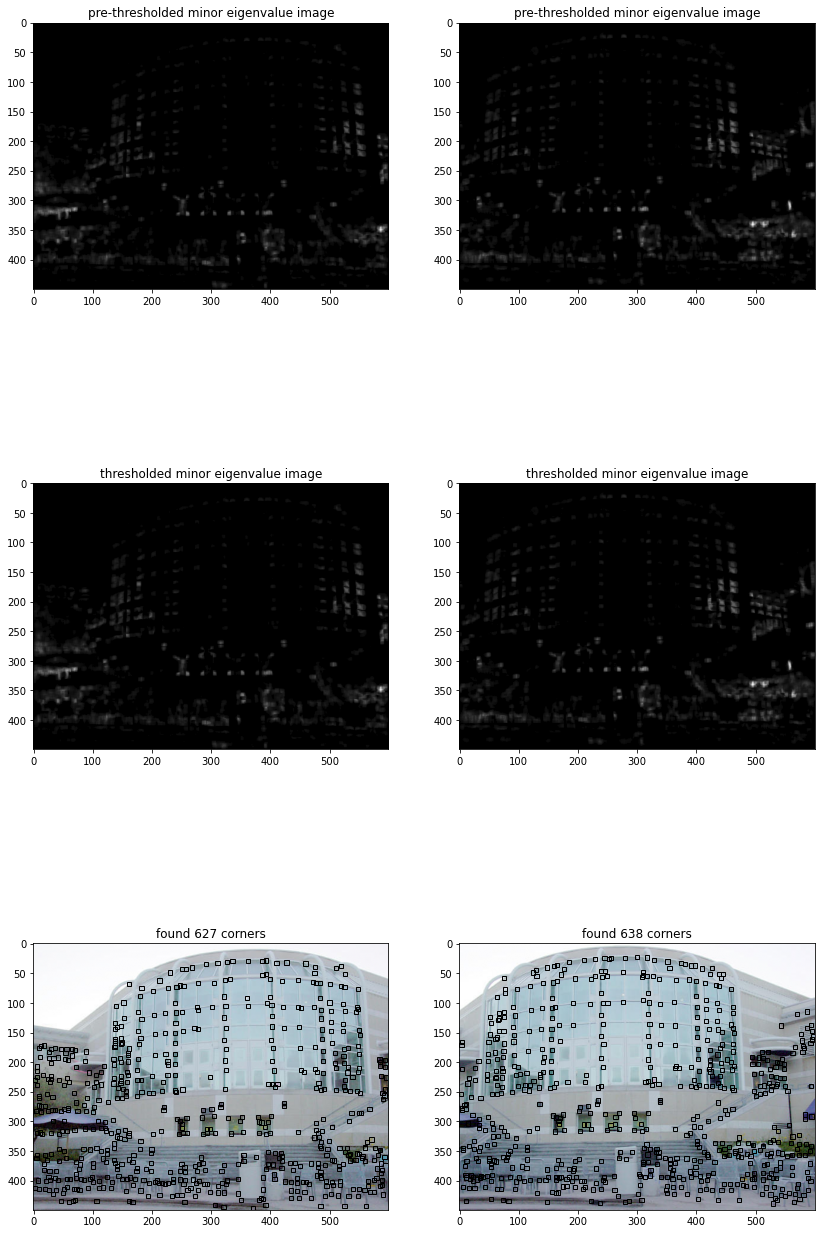

In [3]:
# input images
I1 = np.array(Image.open('price_center20.jpeg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpeg'), dtype='float')/255.

# parameters to tune
w = 7
t = 0.125
w_nms = 7

tic = time.time()
# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show pre-thresholded minor eigenvalue images
plt.subplot(3,2,1)
plt.imshow(J1_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')
plt.subplot(3,2,2)
plt.imshow(J2_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')

# show thresholded minor eigenvalue images
plt.subplot(3,2,3)
plt.imshow(J1_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')
plt.subplot(3,2,4)
plt.imshow(J2_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')

# show corners on original images
ax = plt.subplot(3,2,5)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.title('found %d corners'%C1)

ax = plt.subplot(3,2,6)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 7
* t = 0.125
* w_nms = 7
* C1 = 627
* C2 = 638

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that 160-240 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

**Note: You must center each window at the sub-pixel corner
coordinates while computing normalized cross correlation; otherwise, you
will lose points.**

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

A typical implementation takes around <strong>10</strong> seconds to run. If yours takes more than <strong>30</strong> seconds, you may lose points.

In [4]:
# HELPER FUNCTIONS
def getPatch(I, xc, yc, w):
    '''
    Function performs bilinear interpolation and
    extracts patch centered at (xc,yc)
    '''
    xs = xc-int(w/2)
    ys = yc-int(w/2)
    
    xs0 = int(xs)
    ys0 = int(ys)
    xs1 = xs0 + 1
    ys1 = ys0 + 1
    
    p1 = I[xs0:xs0+w, ys0:ys0+w, :]
    p2 = I[xs1:xs1+w, ys0:ys0+w, :]
    p3 = I[xs0:xs0+w, ys1:ys1+w, :]
    p4 = I[xs1:xs1+w, ys1:ys1+w, :]
            
    I0 = p1*(xs1-xs) + p2*(xs-xs0)
    I1 = p3*(xs1-xs) + p4*(xs-xs0)
    D  = I0*(ys1-ys) + I1*(ys-ys0)
    
    return D

In [5]:
def compute_NCC(p1, p2):
    '''
    given 2 patches, function computes
    the normalized cross correlation 
    score between the 2 patches
    '''
    assert p1.shape == p2.shape, "Patches of different sizes"
    
    p1 = p1 - np.mean(p1)
    p2 = p2 - np.mean(p2)
    # Cross correlation term
    N = np.sum(np.multiply(p1,p2))
    # Auto - correlation term
    D1 = np.sum(np.multiply(p1,p1))
    D2 = np.sum(np.multiply(p2,p2))
    D = np.sqrt(D1*D2)
    return np.min(N/D)

In [6]:
def NCC(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # Do ensure that windows are centered at the sub-pixel co-ordinates 
    #      while computing normalized cross correlation.
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    

    C1 = pts1.shape[1]
    C2 = pts2.shape[1]
    
    P = int(w/2)
    scores = np.zeros((C1,C2))
    
    I1_pad = np.pad(I1.copy(), ((P,P),(P,P),(0,0)), 'constant', constant_values = 0)
    I2_pad = np.pad(I2.copy(), ((P,P),(P,P),(0,0)), 'constant', constant_values = 0)
        
    for i in range(C1):
        for j in range(C2):
            s = -1
            
            # proximity filter
            if np.linalg.norm(pts1[:,i]-pts2[:,j]) < p:
                # Extract patches
                xc1 = pts1[1,i] + P
                yc1 = pts1[0,i] + P
                xc2 = pts2[1,j] + P
                yc2 = pts2[0,j] + P
                
                p1 = getPatch(I1_pad, xc1, yc1, w)
                p2 = getPatch(I2_pad, xc2, yc2, w)
                
                assert p1.shape[0] == w, "Window size mismatch in NCC"
                assert p2.shape[0] == w, "Window size mismatch in NCC"
                
                s = compute_NCC(p1, p2)
                assert s>=-1 or s<=1, 'Invalid NCC value'
            
            scores[i,j] = s

    return scores


def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
    
    inds = []
    mask = np.full(scores.shape, True, dtype=bool)
    scores_orig = scores
    
    print(np.max(scores))
    
    while(np.max(scores) > t):
        idx = np.unravel_index(scores.argmax(), scores.shape)

        # Find max
        best_match = scores[idx]
        scores[idx] = -1

        # Find next best match
        next_best = np.maximum(np.max(scores_orig[idx[0],:]),np.max(scores_orig[:,idx[1]]))
        scores[idx] = best_match
        
        # Append if match good enough
        if((1-best_match) < (1-next_best)*d):
            inds.append(idx)
            
        mask[idx[0],:] = False
        mask[:,idx[1]] = False    
        
        #mask scores matrix 
        scores[np.logical_not(mask)] = -1
    inds = np.array(inds).T
    
    return inds



def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w, p)
    inds = Match(scores, t, d)
    return inds

0.9834502357425764
took 7.045667 secs


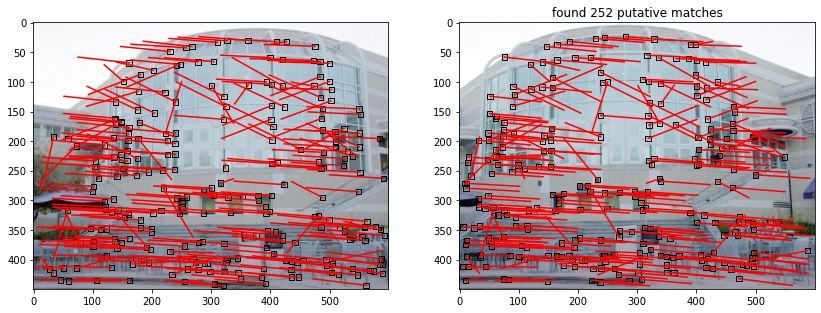

unique points in image 1: 252
unique points in image 2: 252


In [7]:
# parameters to tune
w = 9
t = 0.7
d = .8
p = 100

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]

# display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# test 1-1
print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 19
* t = 0.002
* d = 0.975
* p = 100
* num_matches = 239

## Problem 3 (Programming): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to estimate the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error.

hint: this problem has codimension 2

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image


In [8]:
from scipy.stats import chi2

def DisplayResults(H, title):
    print(title+' =')
    print (H/np.linalg.norm(H)*np.sign(H[-1,-1]))

def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

In [9]:
def compute2DProjTransform(x):
    '''
    Utility function computes the 
    4 points minimum solver for the 
    2D projective transform
    '''
    assert x.shape[0] == 3 , 'shape error'
    
    # Compute lambda
    lam = np.linalg.inv(x[:,:3]) @ x[:,3]
    H_inv = np.multiply(x[:,:3],lam)
    return H_inv

In [10]:
def computeSampsonError(H, x1, x2):
    '''
    Utility function computes the sampson
    error given the H and the set of points.
    Returns the error and correction for 
    each point pair
    '''
    # x1, x2 should be inhomogeneous
    assert x1.shape[0] == 2 ,'Expect inhomogeneous points for sampson error'
       
    h11,h12,h13,h21,h22,h23,h31,h32,h33 = np.ravel(H)
    error = []
    delta = []
    for i in range(x1.shape[1]):
        # Compute sampson error foe each pair of points
        # J matrix
        x_ = x2[0,i]
        y_ = x2[1,i]
        x = x1[0,i]
        y = x1[1,i]
        J = np.array([[-h21 + y_*h31, -h22 + y_*h32, 0 , x*h31 + y*h32 + h33],
                      [ h11 - x_*h31,  h12 - x_*h32,  -x*h31 - y*h32 - h33, 0]])
    
        # Calculate Aih matrix
        epsilon = np.array([-(x*h21 + y*h22 + h23) + y_*(x*h31 + y*h32 + h33),
                        x*h11 + y*h12 + h13 - x_*(x*h31 + y*h32 + h33)])
        
        
        # lambda
        lam = -np.linalg.inv(J @ J.T) @ epsilon
        # Sampson Error
        e = epsilon.T @ np.linalg.inv(J @ J.T) @ epsilon
        error.append(e)
        
        # Delta / Sampson correction
        d = J.T @ lam
        delta.append(d)
    
    error = np.array(error)
    delta = np.array(delta)
    return delta.T, error

5.991464547107979
took 0.158997 secs
21 iterations
inlier count:  167
inliers:  [  0   1   2   3   4   6   8   9  11  12  13  14  15  16  17  18  19  20
  21  22  23  25  26  28  29  30  31  32  33  34  36  37  38  40  41  42
  44  45  46  47  48  50  51  52  54  55  56  57  58  59  60  62  64  66
  69  70  71  72  73  74  76  77  79  80  81  82  84  85  86  87  89  90
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 108 109 110
 111 112 115 117 118 120 121 123 125 126 127 128 129 130 132 133 134 135
 136 138 139 141 142 144 145 147 149 150 151 154 156 158 159 160 161 162
 163 164 166 172 173 174 176 177 180 182 183 184 185 186 189 190 191 192
 193 194 198 199 200 202 211 212 213 215 216 217 220 221 225 227 229 231
 234 235 237 241 242]
MSAC Cost=735.329060891
H_MSAC =
[[ 1.08825642e-02  5.05616162e-05 -9.85965156e-01]
 [ 2.63902467e-04  1.06868197e-02 -1.65936254e-01]
 [ 8.89464467e-07  2.17235526e-07  1.02547456e-02]]


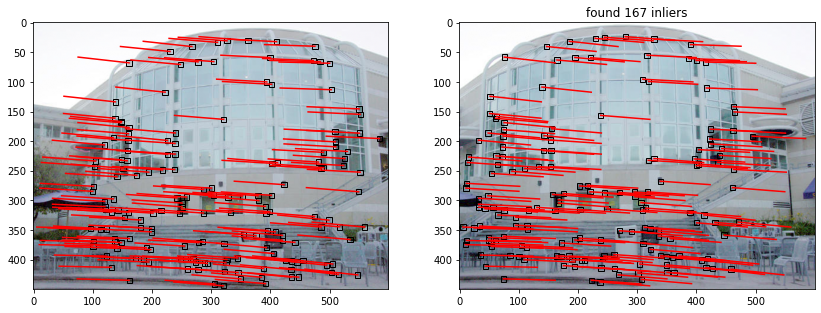

In [11]:
def MSAC(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - planar projective transformation matrix H
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    x1 = Homogenize(pts1)
    x2 = Homogenize(pts2)
        
    consensus_min_cost = np.inf
    trials = 0
    s = 4
    max_trials = np.inf    
    while trials < max_trials:
        trials += 1
        if(consensus_min_cost <= thresh):
            break
        
        # Select random sample
        inliers = np.random.choice(range(pts1.shape[1]), 4, replace=False)
            
        # Calculate Model using Minimum Solver
        H1_inv = compute2DProjTransform(x1[:,inliers])
        H2_inv = compute2DProjTransform(x2[:,inliers])
        H = H2_inv @ np.linalg.inv(H1_inv)
                
        # Compute Consensus cost
        _,consensus_cost = computeSampsonError(H, pts1, pts2)
        inliers_idx = np.array(np.where(consensus_cost <= tol))[0]
        consensus_cost[consensus_cost > tol]  = tol
        consensus_cost = np.sum(consensus_cost)
        
        if consensus_cost < consensus_min_cost:
            # Update Model
            inliers_opt = inliers_idx
            consensus_min_cost = consensus_cost
            consensus_min_cost_model = H

            # Update max_trials
            w = inliers_opt.shape[0]/x1.shape[1]
            max_trials = int(np.log(1-p)/np.log(1-np.power(w,s)))
    
    #consensus_min_cost,inliers_idx = computeSampsonError(consensus_min_cost_model, pts1, pts2 ,tol)
    return consensus_min_cost, consensus_min_cost_model, inliers_opt, trials


# MSAC parameters 
thresh = 200
p = 0.99
alpha = 0.95
tol = chi2.ppf(alpha,df = 2)
print(tol)

tic=time.time()

cost_MSAC, H_MSAC, inliers, trials = MSAC(match1, match2, thresh, tol, p)

# choose just the inliers
xin1 = match1[:,inliers]
xin2 = match2[:,inliers]

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost=%.9f'%cost_MSAC)
DisplayResults(H_MSAC, 'H_MSAC')

# display the figures
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d inliers'%xin1.shape[1])
for i in range(xin1.shape[1]):
    
    x1,y1 = xin1[:,i]
    x2,y2 = xin2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

#### Final values for parameters
* $p$ = 0.9
* $\alpha$ = 0.95
* tolerance = 5.99
* threshold = 0
* num_inliers = 137
* num_attempts = 44

## Problem 4 (Programming): Linear Estimate (15 points)
  Estimate the planar projective transformation $\boldsymbol{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{x}'_i = \boldsymbol{H} \boldsymbol{x}_i$ as
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}'_i \times \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{x}'_i = \boldsymbol{0}$, when forming the
  solution. Return $\boldsymbol{H}_\text{DLT}$, scaled such that
  $||\boldsymbol{H}_\text{DLT}||_\text{Fro} = 1$

In [12]:
xin1=np.loadtxt('hw4_pts1.txt').T
xin2=np.loadtxt('hw4_pts2.txt').T

In [13]:
def Normalize(pts):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    
    # Compute mean and variance of each dimension
    m = np.mean(pts,1).reshape(-1,1)
    v = np.var(pts,1).reshape(-1,1)
    s = np.sqrt(m.shape[0]/np.sum(v))
        
    # Create Transformation matrix
    T = np.eye(pts.shape[0]+1)
    for i in range(T.shape[0]-1):
        T[i,i] = s
        T[i,-1] = -m[i]*s
         
    # Normalize each set of points
    pts_h = Homogenize(pts)
    for i in range(pts.shape[1]):
        pts_h[:,i] = np.matmul(T, pts_h[:,i])
    return pts_h, T

In [14]:
def computeKronickerTerm(x1, x2):
    '''
    Computes the left null-space of x2 and 
    its kronicker product with x1
    '''
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    u, s, vh = np.linalg.svd(x2, full_matrices=True)
    lns1 = u[:,s.shape[0]:x2.shape[0]].T
    
    A = np.kron(lns1,x1.T)
    return A

In [15]:
def DLT(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 1
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    H - the DLT estimate of the planar projective transformation   
    #    cost - Sampson cost for the above DLT Estimate H. Assume points in image 1 as scene points.
        
    # data normalization
    if normalize:
        x1_norm, T1 = Normalize(x1)
        x2_norm, T2 = Normalize(x2)
    else:
        x1_norm = Homogenize(x1)
        x2_norm = Homogenize(x2)
    
    N = x1.shape[1]
    A = []
    for i in range(N):
        A.append(computeKronickerTerm(x1_norm[:,i], x2_norm[:,i]))
    A = np.concatenate(A)
    _, _, vh = np.linalg.svd(A, full_matrices=True)
    H = vh[-1,:].reshape(3,3)
        
    # data denormalize
    if normalize:
        H = np.linalg.inv(T2) @ H @ T1
    
    # Calculate sampson error
    delta,cost = computeSampsonError(H, x1, x2)
    cost = np.sum(cost)
    H = H / np.linalg.norm(H)
    return H, cost


# compute the linear estimate without data normalization
print ('Running DLT without data normalization')
time_start=time.time()
H_DLT, cost = DLT(xin1, xin2, normalize=False)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)


# compute the linear estimate with data normalization
print ('Running DLT with data normalization')
time_start=time.time()
H_DLT, cost = DLT(xin1, xin2, normalize=True)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)

Running DLT without data normalization
took 0.016477 secs
Cost=28.017269816
Running DLT with data normalization
took 0.012603 secs
Cost=26.861263396


In [16]:


# display your H_DLT, scaled with its frobenius norm
DisplayResults(H_DLT, 'H_DLT')

H_DLT =
[[ 1.10272655e-02 -3.52204170e-05 -9.84954996e-01]
 [ 3.18273363e-04  1.07218660e-02 -1.71817315e-01]
 [ 1.25076546e-06  4.52935210e-08  1.02861866e-02]]


## Problem 5 (Programming): Nonlinear Estimate (45 points) 
 Use $\boldsymbol{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors.
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the planar projective transformation matrix $\boldsymbol{H}_\text{LM}$, scaled
  such that $||\boldsymbol{H}_\text{LM}||_\text{Fro} = 1$.

In [17]:
def ParameterizeHomog(V):
    # Given a homogeneous vector V return its minimal parameterization
        
    v_hat = 2*V[1:]/Sinc(np.arccos(V[0]))    
    
    if np.linalg.norm(v_hat) > np.pi:
        v_hat = (1 - 2*np.pi/np.linalg.norm(v_hat)*np.ceil((np.linalg.norm(v_hat)-np.pi)/(2*np.pi)))*v_hat
        
    return v_hat

def parameterize(H, x):
    '''
    Parametrize H matrix and scene points
    '''
    # H - 3x3 matrix, x - 3xn
    assert H.shape[0] == 3 and H.shape[1] == 3, 'Expect a 3x3 H matrix'
    assert x.shape[0] == 3 , 'scene points not homogenized'
        
    # parametrize H matrix
    H = H/np.linalg.norm(H)*np.sign(H[-1,-1])
    h = H.reshape(-1,1)
    h = ParameterizeHomog(h)
    
    # Parametrize each of the sampson corrected 
    # scene points
    x = x/np.linalg.norm(x, axis = 0)
    x_s_param = np.zeros((2, x.shape[1]))
    
    for i in range(x.shape[1]):
        x_s_param[:,i] = ParameterizeHomog(x[:,i]/np.linalg.norm(x[:,i])*np.sign(x[-1,i]))
        
    return h, x_s_param

In [18]:
def DeParameterizeHomog(v):
    # Given a parameterized homogeneous vector return its deparameterization
    assert v.shape[1] == 1, 'Expect a nx1 vec in Deparam'
    a = np.array([[np.cos(np.linalg.norm(v)/2)]])
    b = v*Sinc(np.linalg.norm(v)/2)/2
    v_bar = np.vstack((a,b))
    
    return v_bar

In [19]:
def Sinc(x):
    # Returns a scalar valued sinc value
    if x == 0:
        y = 1
    else:
        y =  np.sin(x)/x
    return y

In [20]:
def Deparameterize(h_param, xs_param):
    '''
    Deparametrization of homogeneous vectors
    '''
    H = DeParameterizeHomog(h_param).reshape(3,3)
    xs = np.zeros((3,xs_param.shape[1]))
    for i in range(xs_param.shape[1]):
        xs[:,i] = DeParameterizeHomog(xs_param[:,i].reshape(-1,1)).T
    return H, xs

In [21]:
def jacobianHomoParam(p):
    '''
    Helper function to compute derivative of 
    a deparam vector with a param vector.
    Param of homo representation.
    Based on (6)
    p - parametrized vector
    '''
    P_ = DeParameterizeHomog(p).reshape(1,-1)
    if (np.linalg.norm(p) == 0):
        # Norm of p is 0
        da_dv = np.zeros((1,p.shape[0]))
        db_dv = 0.5*np.eye(p.shape[0])
    else:
        # da/dv
        da_dv = -0.5*P_[0,1:]
        # ||v|| term
        v_norm = np.linalg.norm(p)
        
        # derivative of sinc
        d_sinc = np.cos(v_norm/2)/(v_norm/2) -\
        np.sin(v_norm/2)/np.square(v_norm/2)
        
        # db/dv    
        db_dv = Sinc(v_norm/2)/2*np.eye(p.shape[0]) + \
         d_sinc * np.matmul(p,p.T)/(4*v_norm)
    
    dp_bar_dp = np.vstack((da_dv, db_dv))
    assert dp_bar_dp.shape[0] == p.shape[0]+1 and dp_bar_dp.shape[1] == p.shape[0] , "Jacobian param error"
    
    return dp_bar_dp

In [22]:
def solveAugmentedNormEq(U, V, W, epsA, epsB, lam):
    '''
    Solves the augmented normal equations
    U - 8x8 matrix
    V,W- list
    epsA - 8x1 matrix
    epsB - list
    '''
    assert U.shape[0] == U.shape[1] and U.shape[0] == 8, 'U shape issue'
    
    S = U + lam*np.eye(8)
    e = epsA
    for i in range(len(V)):
        S = S - W[i] @ np.linalg.inv(V[i] + lam*np.eye(2)) @ W[i].T
        e = e - W[i] @ np.linalg.inv(V[i] + lam*np.eye(2)) @ epsB[i]
    
    assert S.shape[0] == S.shape[1] and S.shape[1] == 8 , 'S shape incorrect'
    assert e.shape[0] == 8 and e.shape[1] == 1 , 'e shape incorrect'
    
    DeltaA = np.linalg.inv(S) @ e
    assert DeltaA.shape[0] == 8 and DeltaA.shape[1] == 1, 'delta a shape issue'
    DeltaB = []
    for i in range(len(V)):
        deltaB = np.linalg.inv(V[i] + lam*np.eye(2))  @ (epsB[i] - W[i].T @ DeltaA)
        DeltaB.append(deltaB)
    return DeltaA, DeltaB

In [23]:
def computeNormalEqVec(A_, B_, B, Covarx1, Covarx2, h_param, xs_param, x1, x2):
    '''
    Computes the entries of the normal vector
    '''
    # Get inhomogeneous image points
    # in img1, img2 
    
    H, xs = Deparameterize(h_param, xs_param)
        
    x1_res = Dehomogenize(x1) - Dehomogenize(np.eye(3) @ xs)
    x2_res = Dehomogenize(x2) - Dehomogenize(H @ xs) 
    EpsA = np.zeros((8,1))
    EpsB = []
    
    for i in range(len(A_)):
        covarx1 = np.linalg.inv(Covarx1[2*i:2*i+2,2*i:2*i+2])
        covarx2 = np.linalg.inv(Covarx2[2*i:2*i+2,2*i:2*i+2])
        EpsA = EpsA + A_[i].T @ covarx2 @ x2_res[:,i].reshape(-1,1)
        epsB = B[i].T @ covarx1 @ x1_res[:,i].reshape(-1,1) + B_[i].T @ covarx2 @ x2_res[:,i].reshape(-1,1)
        
        assert epsB.shape[0] == 2 and epsB.shape[1] == 1 ,'Shape error for epsB'
        
        EpsB.append(epsB)
        
    assert EpsA.shape[0] == 8 and EpsA.shape[1] == 1 ,'Shape error for epsA'
    return EpsA, EpsB

In [24]:
def computeNormalEqMat(A_, B_, B, Covarx1, Covarx2):
    '''
    Computes entries of the Normal equation matrix
    A_,B_,B - list 
    '''    
    U = np.zeros((8,8))
    V = []
    W = []
    for i in range(len(B)):
        covarx1 = np.linalg.inv(Covarx1[2*i:2*i+2,2*i:2*i+2])
        covarx2 = np.linalg.inv(Covarx2[2*i:2*i+2,2*i:2*i+2])
        U = U + A_[i].T @ covarx1 @ A_[i]
        v = B[i].T @ covarx1 @ B[i] + B_[i].T @ covarx2 @ B_[i]
        w = A_[i].T @ covarx2 @ B_[i]
        
        assert v.shape[0] == 2 and v.shape[1] == 2, 'Error in V shape'
        assert w.shape[0] == 8 and w.shape[1] == 2, 'Error in W shape'
        
        W.append(w)
        V.append(v)
    
    return U,V,W        

In [25]:
def Normalize_withCov(pts, covarx):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    #    covarx - covariance matrix associated with x. Has size 2n x 2n, where n is number of points.
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    #    covarx - normalized covariance matrix
    
    # Compute mean and variance of each dimension
    m = np.mean(pts,1).reshape(-1,1)
    v = np.var(pts,1).reshape(-1,1)
    s = np.sqrt(m.shape[0]/np.sum(v))
        
    # Create Transform matrix
    T = np.eye(pts.shape[0]+1)
    for i in range(T.shape[0]-1):
        T[i,i] = s
        T[i,-1] = -m[i]*s
         
    # Normalize each set of points
    pts_h = Homogenize(pts)
    for i in range(pts.shape[1]):
        pts_h[:,i] = np.matmul(T, pts_h[:,i])
    
    # Covariance propagation
    covarx = (s*s)*covarx
    
    return pts_h, T, covarx

In [26]:
def computeJocabian(h, xs_param):
    '''
    Compute jacobian
    h,xs - parametrized H matrix and 
    scene points
    '''
    # Get inhomogeneous image points
    # in img1, img2 
    H, xs = Deparameterize(h, xs_param)
            
    x1 = Dehomogenize(np.eye(3) @ xs)
    x2 = Dehomogenize(H @ xs) 
    
    # Jacobian of x2 wrt h
    A_list = []
    # Jacobian of x2 wrt s2
    B_list = []
    # Jacobian of x1 wrt s2
    Blist  = []
    
    # derivative of deparam h wrt param h (6)
    a2 = jacobianHomoParam(h)
    assert a2.shape[0] == 9 and a2.shape[1] == 8, 'A_ Jacobian error 2'
        
    for i in range(x1.shape[1]):
        #-------------------------------------------------------------------
        # A_ =  a1 @ a2
        w = H[-1,:] @ xs[:,i]
        # derivative of img2 wrt deparam h (26)
        a1_1 = np.hstack((xs[:,i].reshape(1,-1) , np.zeros((1,3)), -x2[0,i]*xs[:,i].reshape(1,-1)))
        a1_2 = np.hstack((np.zeros((1,3)), xs[:,i].reshape(1,-1), -x2[1,i]*xs[:,i].reshape(1,-1)))
                
        a1 = np.vstack((a1_1, a1_2))
        a1 = a1/w
        
        # derivative of deparam h wrt param h (6)
        # a2 is constant across points
        assert a1.shape[0] == 2 and a1.shape[1] == 9, 'A_ Jacobian error 1'
        A_ = a1 @ a2        
        A_list.append(A_)
        
        #-------------------------------------------------------------------
        # B = b1 @ b2
        # Derivative of image1 pts wrt scene points
        H_ = np.eye(3)
        w = H_[-1,:] @ xs[:,i]
        b1 = np.vstack((H_[0,:]- x1[0,i]*H_[-1,:] , H_[1,:]- x1[1,i]*H_[-1,:]))
        b1 = b1/w
        
        # derivative of deparam scene points wrt param scene points
        b2 = jacobianHomoParam(xs_param[:,i].reshape(-1,1))
        assert b1.shape[0] == 2 and b1.shape[1] == 3, 'B Jacobian error 1'
        assert b2.shape[0] == 3 and b2.shape[1] == 2, 'B Jacobian error 2'
                
        B = b1 @ b2
        Blist.append(B)
        
        #-------------------------------------------------------------------
        # B_ = b1_ @ b2_
        # Derivative of image2 pts wrt scene points
        w = H[-1,:] @ xs[:,i]
        b1_ = np.vstack((H[0,:]- x2[0,i]*H[-1,:] , H[1,:]- x2[1,i]*H[-1,:]))
        b1_ = b1_/w
        
        assert b1_.shape[0] == 2 and b1_.shape[1] == 3, 'B Jacobian error 1'
               
        B_ = b1_ @ b2
        B_list.append(B_)
    
    return A_list, B_list, Blist

In [27]:
def computeResidualCost(H, xs, x1, x2, Covarx1,Covarx2):
    '''
    Calcualate residual error
    '''
    # Doubt - cost calculation in deparameterized residual space??
    assert xs.shape[0] == 3, 'Expecting 3D scene points'
    assert Covarx1.shape[0] == 2*xs.shape[1], 'N not matching'
    assert x1.shape[0] == 3 , 'image points not in inhomo'
    
    res1 = Dehomogenize(x1) - Dehomogenize(xs)
    res2 = Dehomogenize(x2) - Dehomogenize(H @ xs)
    
    res1 = res1.ravel('F')
    res2 = res2.ravel('F')
    cost = res1.T @ np.linalg.inv(Covarx1) @ res1 + res2.T @ np.linalg.inv(Covarx2) @ res2
    return cost

In [28]:
from scipy.linalg import block_diag

def LM(H, x1, x2, max_iters, lam):
    # Input:
    #    H - Initial estimate of planar projective transformation matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    H - Final H (3x3) obtained after convergence
    
    # Data normalization.
    covarx = np.eye(2*x1.shape[1])
    x1_norm, T1, covarx1 = Normalize_withCov(x1, covarx)
    x2_norm, T2, covarx2 = Normalize_withCov(x2, covarx)
    H_norm = T2 @ H @ np.linalg.inv(T1)
    H_norm = H_norm/np.linalg.norm(H_norm)*np.sign(H_norm[-1,-1])
    
    # Initialize scene points using sampson error on 
    # DN image points1
    delta,_ = computeSampsonError(H_norm, Dehomogenize(x1_norm), Dehomogenize(x2_norm))
    xs = Dehomogenize(x1_norm) + delta[:2,:] # 2xn
    xs_homo = Homogenize(xs) # 3xn
        
    # LM
    cost_prev = computeResidualCost(H_norm, xs_homo, x1_norm, x2_norm, covarx1, covarx2)
    n_iters = 0
    
    # Parametrize
    h_param, xs_param = parameterize(H_norm, xs_homo) # 2xn
    
    while (n_iters < max_iters):
        # Paramaterize H and scene points using 
        # parametrization of homogeneous vector
        
        # Calculate Jacobian
        A_list, B_list, Blist = computeJocabian(h_param, xs_param)
        
        # Compute Normal Equation Matrix
        U,V_list,W_list = computeNormalEqMat(A_list, B_list, Blist, covarx1, covarx2) # Should return U,V,W
        
        # Compute Normal Equation Vector
        epsA, epsB_list = computeNormalEqVec(A_list, B_list, Blist, covarx1, covarx2, h_param, xs_param, x1_norm, x2_norm) #  Should return epsilonA, epsilonB
                
        # Solve Augmented equation
        deltaA, deltaB = solveAugmentedNormEq(U, V_list, W_list, epsA, epsB_list, lam)
        
        # Get candidate
        h_param_c = h_param + deltaA
        xs_param_c = []
        for i in range(xs_param.shape[1]):
            xs_param_c.append(xs_param[:,i].reshape(-1,1) + deltaB[i])
        xs_param_c = np.concatenate(xs_param_c, axis = 1)
        xs_param_c = xs_param_c.reshape(2,-1)
        
        # Deparametrize
        H_c, xs_deparam_c = Deparameterize(h_param_c, xs_param_c)
        
        # Use adjusted H and identity matrix to calculate residual i.e. cost
        cost = computeResidualCost(H_c, xs_deparam_c, x1_norm, x2_norm, covarx1, covarx2)
                
        # LM Stopping conditions
        if (1 - cost/cost_prev < 1e-12):
            break
        
        if cost < cost_prev:
            # Valid iteration
            print ('iter %03d Cost %.9f'%(n_iters+1, cost))
            lam = lam/10
            h_param = h_param_c
            xs_param = xs_param_c
            H = H_c
            cost_prev = cost
            n_iters = n_iters + 1
        else:
            lam = lam * 10
      
    # data denormalization
    H = np.linalg.inv(T2) @ H @ T1
    
    return H


# LM hyperparameters
lam = .001
max_iters = 100

# Run LM initialized by DLT estimate with data normalization
print ('Running sparse LM with data normalization')
print ('iter %03d Cost %.9f'%(0, cost))
time_start=time.time()
H_LM = LM(H_DLT, xin1, xin2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

Running sparse LM with data normalization
iter 000 Cost 26.861263396
iter 001 Cost 26.750739809
iter 002 Cost 26.750725143
iter 003 Cost 26.750725141
took 0.222850 secs


In [29]:
# display your converged H_LM, scaled with its frobenius norm
DisplayResults(H_LM, 'H_LM')

H_LM =
[[ 1.10196827e-02 -3.13529030e-05 -9.84841088e-01]
 [ 3.19163756e-04  1.07181144e-02 -1.72470097e-01]
 [ 1.24768789e-06  5.10210891e-08  1.02802415e-02]]
